Use this notebook to train the model for your own images. The only things you need to change is the Args class which contains path to your images and the content and style weight in cell 8. The style of this notebook follows from the original code release of the paper which can be found [here](https://github.com/limingcv/Photorealistic-Style-Transfer/blob/master/Photorealistic%20Style%20Transfer/transfer.ipynb)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19 

from PIL import Image
import numpy as np 
from tqdm import tqdm 
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, '../src/')
from hrnet import HRNet
from utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Dummy class to model get_parser
class Args:
    def __init__(self):
        self.img_root = '../src/imgs'
        self.content_img = 'content1.png'
        self.style_img = 'style1.png'
        self.use_gpu = True
        
args = Args()

In [3]:
if args.use_gpu:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        raise Exception('GPU is not available')
else:
    device = torch.device('cpu')
    
# Load VGG19 features
vgg = vgg19(pretrained=True).features
vgg = vgg.to(device)
# We don't want to train VGG
for param in vgg.parameters():
    param.requires_grad_(False)
    
# Load style net
style_net = HRNet()
style_net = style_net.to(device)

torch.backends.cudnn.benchmark = True

In [4]:
# Load images
content_img = load_image(os.path.join(args.img_root, args.content_img), size=500)
content_img = content_img.to(device)

style_img = load_image(os.path.join(args.img_root, args.style_img))
style_img = style_img.to(device)

In [5]:
content_img.size(), style_img.size()

(torch.Size([1, 3, 500, 500]), torch.Size([1, 3, 1067, 600]))

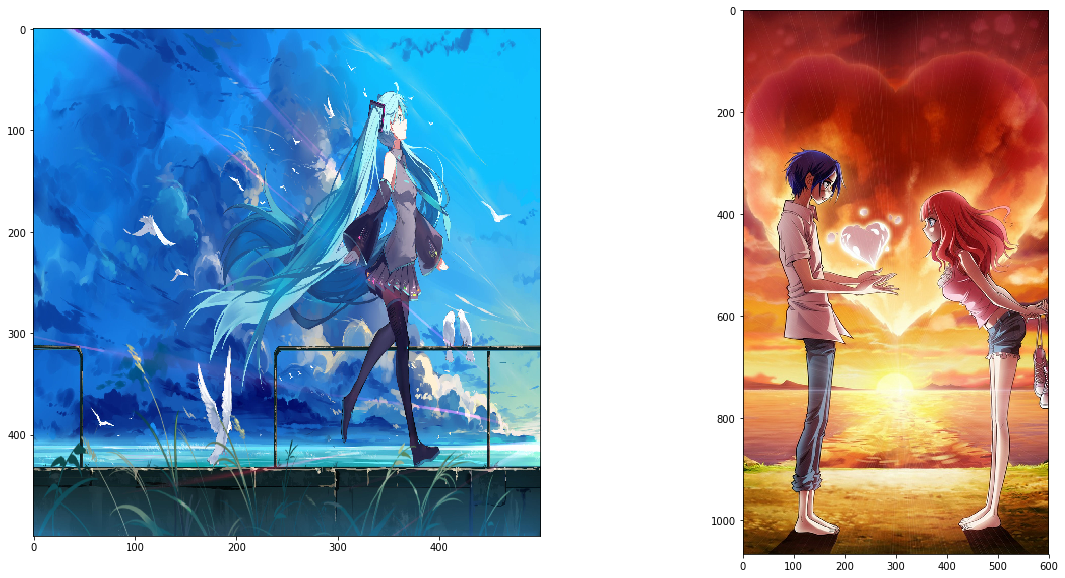

In [6]:
# Show content and style image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content_img))
ax2.imshow(im_convert(style_img))
plt.show()

In [7]:
# Get features from VGG19
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

style_gram_matrixs = {layer: get_gram_matrix(style_features[layer]) for layer in style_features}

target = content_img.clone().requires_grad_(True).to(device)

In [8]:
style_weights = {
     'conv1_1': 0.1,
     'conv2_1': 0.2,
     'conv3_1': 0.4,
     'conv4_1': 0.8,
     'conv5_1': 1.6
}

content_weight = 150
style_weight = 1

show_every = 100
optim = torch.optim.Adam(style_net.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=200, gamma=0.9)
steps = 1000

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []
output_image = content_img

  0%|          | 0/1001 [00:00<?, ?it/s]

After 0 criterions:
Total loss:  3239.425048828125
Content loss:  11.790567398071289
Style loss:  1470.8399658203125


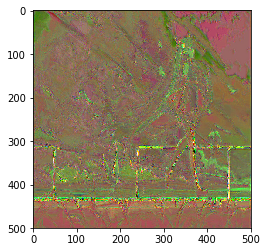

 10%|▉         | 100/1001 [01:32<12:42,  1.18it/s]

After 100 criterions:
Total loss:  711.1990356445312
Content loss:  2.343580484390259
Style loss:  359.6619567871094


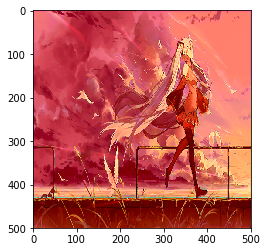

 20%|█▉        | 200/1001 [03:00<11:25,  1.17it/s]

After 200 criterions:
Total loss:  605.0673217773438
Content loss:  1.9049595594406128
Style loss:  319.3233947753906


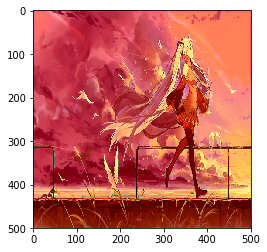

 20%|██        | 203/1001 [03:02<11:09,  1.19it/s]

In [ ]:
for epoch in tqdm(range(0, steps+1)):
    scheduler.step()
    
    target = style_net(content_img).to(device)
    target.requires_grad_(True)
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram_matrix = get_gram_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c*h*w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss_epoch.append(total_loss.item())
    
    style_loss_epoch.append(style_weight * style_loss)
    content_loss_epoch.append(content_weight * content_loss.item())
    
    optim.zero_grad()
    total_loss.backward()
    optim.step()
    
    if epoch % show_every == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

    output_image = target